# **Klasifikasi Gambar Pizza**

## **Sumber Dataset**
https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza/data

## **Import Libraries**

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **Data Loading**

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d carlosrunner/pizza-not-pizza

!unzip pizza-not-pizza.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza
License(s): other
 99% 100M/101M [00:05<00:00, 24.5MB/s] 
100% 101M/101M [00:05<00:00, 18.4MB/s]
Archive:  pizza-not-pizza.zip
  inflating: pizza_not_pizza/food101_subset.py  
  inflating: pizza_not_pizza/not_pizza/1005746.jpg  
  inflating: pizza_not_pizza/not_pizza/1009225.jpg  
  inflating: pizza_not_pizza/not_pizza/1012312.jpg  
  inflating: pizza_not_pizza/not_pizza/1018802.jpg  
  inflating: pizza_not_pizza/not_pizza/1020735.jpg  
  inflating: pizza_not_pizza/not_pizza/1027142.jpg  
  inflating: pizza_not_pizza/not_pizza/102839.jpg  
  inflating: pizza_not_pizza/not_pizza/1043233.jpg  
  inflating: pizza_not_pizza/not_pizza/1045400.jpg  
  inflating: pizza_not_pizza/not_pizza/104773.jpg  
  inflating: pizza_not_pizza/not_pizza/1050956.jpg  
  inflating: pizza_not_pizza/not_pizza/1054362.jpg  
  inflating: pizza_not_pizza/not_pizza/1062097.jpg  
  inflating: pizza_not_pizza/

## **Plot Sample Data**

Pizza Images:


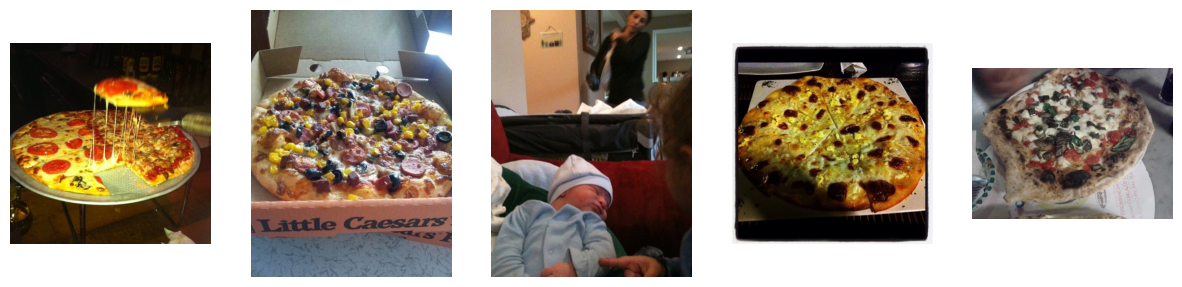


Not Pizza Images:


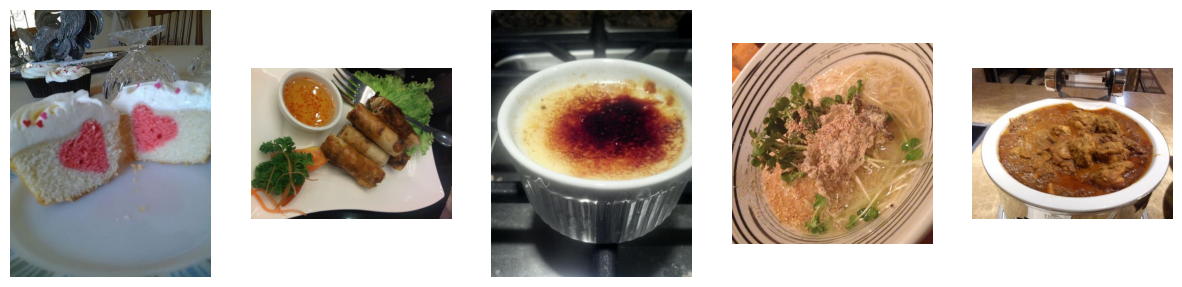

In [3]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# Define the paths to your pizza and not-pizza folders
pizza_folder = "pizza_not_pizza/pizza"
not_pizza_folder = "pizza_not_pizza/not_pizza"

# Function to display images
def display_images(folder_path, num_images=5):
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if len(image_files) < num_images:
        num_images = len(image_files)
    selected_images = random.sample(image_files, num_images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(folder_path, image_file)
        try:
            img = Image.open(image_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
    plt.show()

# Display 5 random pizza images
print("Pizza Images:")
display_images(pizza_folder)


# Display 5 random not-pizza images
print("\nNot Pizza Images:")
display_images(not_pizza_folder)

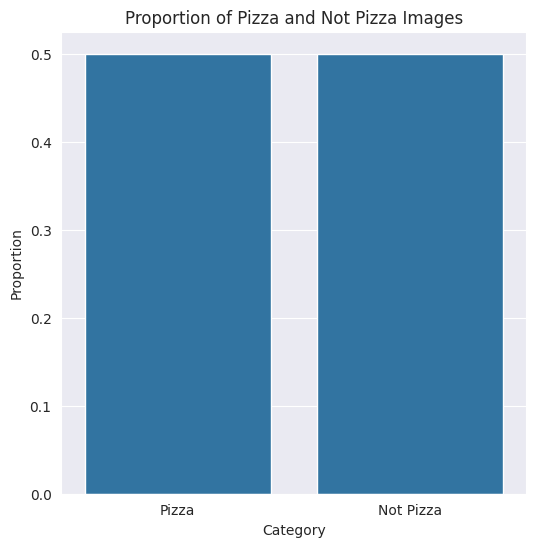

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Create a list of image paths and their corresponding labels
image_paths = []
labels = []

for filename in os.listdir(pizza_folder):
    image_paths.append(os.path.join(pizza_folder, filename))
    labels.append('pizza')

for filename in os.listdir(not_pizza_folder):
    image_paths.append(os.path.join(not_pizza_folder, filename))
    labels.append('not_pizza')

# Create a DataFrame
distribution_train = pd.DataFrame({'image_paths': image_paths, 'labels': labels})

# Calculate the proportions
pizza_proportion = distribution_train[distribution_train['labels'] == 'pizza'].shape[0] / distribution_train.shape[0]
not_pizza_proportion = 1 - pizza_proportion

# Create a DataFrame for the bar chart
proportion_df = pd.DataFrame({
    'Category': ['Pizza', 'Not Pizza'],
    'Proportion': [pizza_proportion, not_pizza_proportion]
})

# Create the bar chart
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.barplot(x='Category', y='Proportion', data=proportion_df)
plt.title('Proportion of Pizza and Not Pizza Images')
plt.ylabel('Proportion')
plt.show()

"Balance" antara kedua label

In [5]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'pizza_not_pizza/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
not_pizza    983
pizza        983
dtype: int64

Untuk meningkatkan akurasi model maka akan dilakukan penambahan data pada kedua label

## **Data Augmentation**

In [6]:
# Define image augmentation parameters
rotation_range = 20
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.2
zoom_range = 0.2
horizontal_flip = True
fill_mode = 'nearest'

# Create ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    fill_mode=fill_mode
)

# Function to augment images
def augment_images(image_dir, label, num_augmentations=5):
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    for image_file in image_files:
        img_path = os.path.join(image_dir, image_file)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=image_dir, save_prefix=f'aug_{label}_{i}', save_format='jpeg'):
            i += 1
            if i >= num_augmentations:
                break


# Augment pizza images
augment_images(pizza_folder, 'pizza')

# Augment not-pizza images
augment_images(not_pizza_folder, 'not_pizza')

In [7]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'pizza_not_pizza/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
not_pizza    4882
pizza        4890
dtype: int64

## **Data Splitting**

In [8]:
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300, shuffle = True)

Shuffle disetting kedalam TRUE karena kita ingin gambar pada model uji lebih bervariasi(bukan hanya gambar bawah pada urutan file)

In [9]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [10]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 7817
test size 1955


In [11]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   not_pizza     978
       pizza         977
train  not_pizza    3904
       pizza        3913
dtype: int64 


                                                   path     labels    set
4979  pizza_not_pizza/not_pizza/aug_not_pizza_0_0_93...  not_pizza  train
8965  pizza_not_pizza/not_pizza/aug_not_pizza_0_0_28...  not_pizza   test
6790      pizza_not_pizza/pizza/aug_pizza_0_0_1496.jpeg      pizza  train
1296  pizza_not_pizza/not_pizza/aug_not_pizza_0_0_98...  not_pizza  train
9687      pizza_not_pizza/pizza/aug_pizza_0_0_9610.jpeg      pizza   test


In [12]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "pizza_not_pizza/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [13]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## **Image Data Generator**

In [14]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_pizza = os.path.join(TRAIN_DIR + '/pizza')
train_not_pizza = os.path.join(TRAIN_DIR + '/not_pizza')
test_pizza = os.path.join(TEST_DIR + '/pizza')
test_not_pizza = os.path.join(TEST_DIR + '/not_pizza')

print("Total number of pizza images in training set: ",len(os.listdir(train_pizza)))
print("Total number of not a pizza images in training set: ",len(os.listdir(train_not_pizza)))
print("Total number of pizza images in test set: ",len(os.listdir(test_pizza)))
print("Total number of not a pizza images in test set: ",len(os.listdir(test_not_pizza)))

Total number of pizza images in training set:  3913
Total number of not a pizza images in training set:  3904
Total number of pizza images in test set:  977
Total number of not a pizza images in test set:  978


In [15]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 6255 images belonging to 2 classes.
Found 1562 images belonging to 2 classes.
Found 1955 images belonging to 2 classes.


## **Model Training**

In [16]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu',kernel_regularizer=l2(0.01)))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.01)))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='binary_crossentropy',
                metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,402,881 (5.35 MB)

 Trainable params: 1,402,689 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Change the filepath to end with '.keras'
filepath = "model_cnn.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False)
reduceLR = ReduceLROnPlateau( monitor='val_loss',
                                factor=0.2,
                                patience=3,
                                verbose=1,
                                mode='auto',
                                min_delta=0.0001,
                                min_lr = 0.00000001)
early_stop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            verbose=1,
                            mode='auto',
                            start_from_epoch=0)

In [19]:
history=model_1.fit(train_generator,batch_size=32,epochs=100,validation_data=validation_generator,verbose=1,callbacks=[checkpoint, early_stop, reduceLR])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5851 - loss: 4.7628
Epoch 1: val_loss improved from inf to 1.72566, saving model to model_cnn.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 35s 129ms/step - accuracy: 0.5854 - loss: 4.7503 - val_accuracy: 0.5019 - val_loss: 1.7257 - learning_rate: 0.0010
Epoch 2/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6892 - loss: 1.2719
Epoch 2: val_loss improved from 1.72566 to 1.36241, saving model to model_cnn.keras
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.6895 - loss: 1.2693 - val_accuracy: 0.5038 - val_loss: 1.3624 - learning_rate: 0.0010
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7689 - loss: 0.6696
Epoch 3: val_loss did not improve from 1.36241
196/196 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - accuracy: 0.7689 - loss: 0.6694 - val_accuracy: 0.5051 - val_loss: 1.5516 - learning_rate: 0.0010
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7794 - loss: 0.5880
Epoch 4: val_loss i

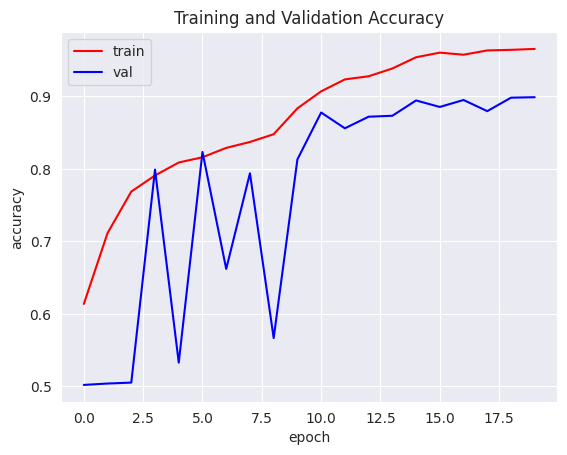

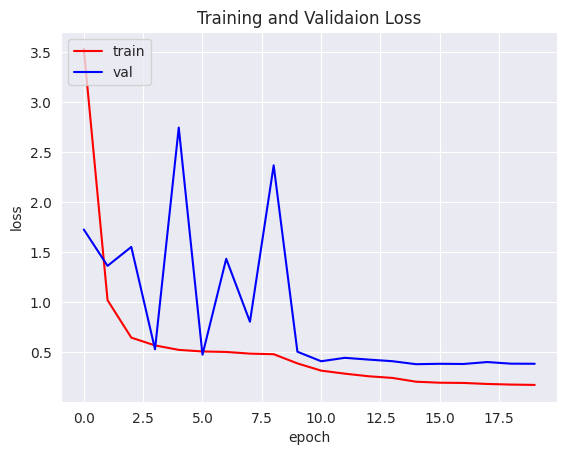

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

       Pizza     0.8497    0.8783    0.8638       978
   Not Pizza     0.8739    0.8444    0.8589       977

    accuracy                         0.8614      1955
   macro avg     0.8618    0.8614    0.8613      1955
weighted avg     0.8618    0.8614    0.8613      1955



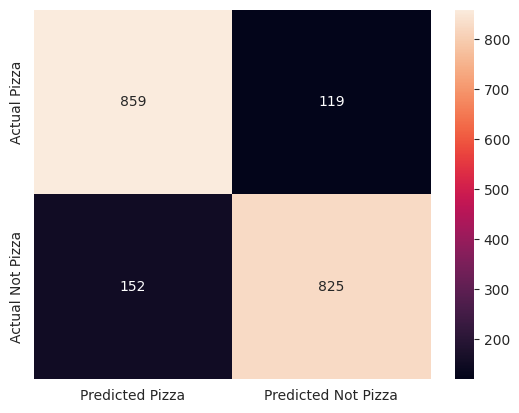

In [21]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1 = preds_1.copy()
preds_1[preds_1 <= 0.5] = 0
preds_1[preds_1 > 0.5] = 1

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual Pizza", "Actual Not Pizza"],
columns=["Predicted Pizza", "Predicted Not Pizza"])
sns.heatmap(cm,annot=True,fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Pizza','Not Pizza'], digits=4))

1955/1955 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


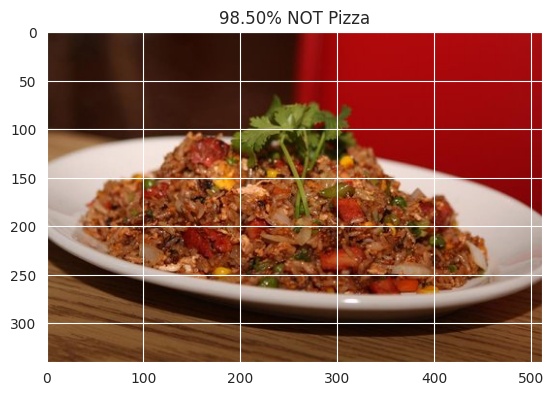

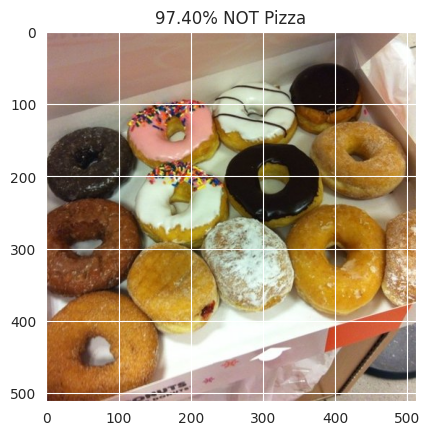

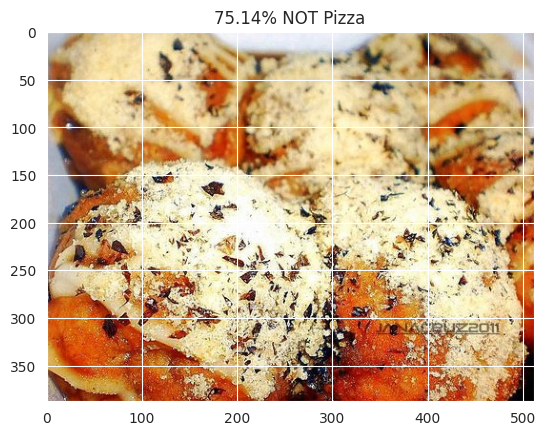

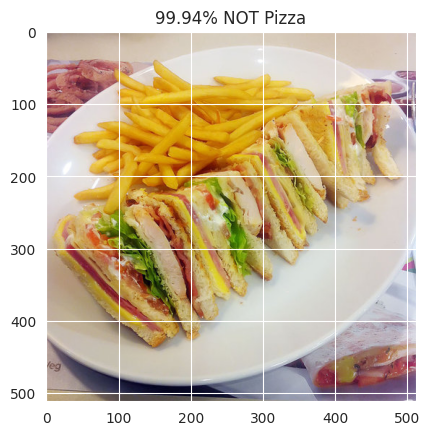

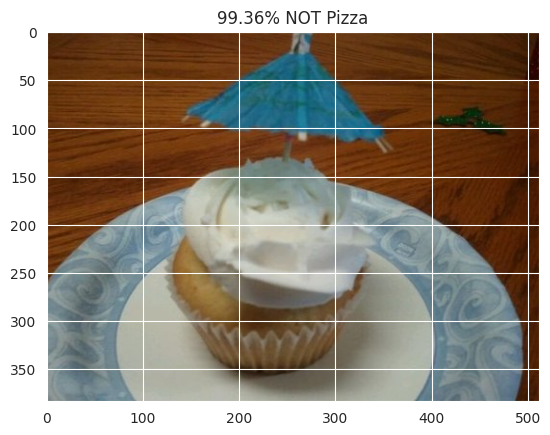

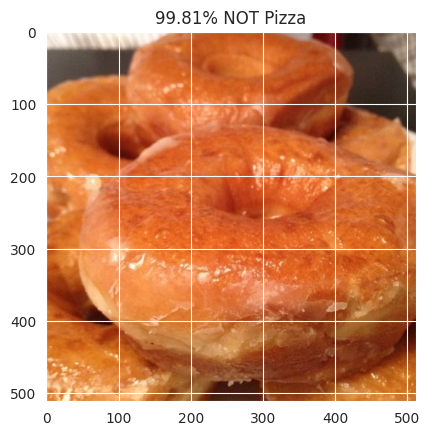

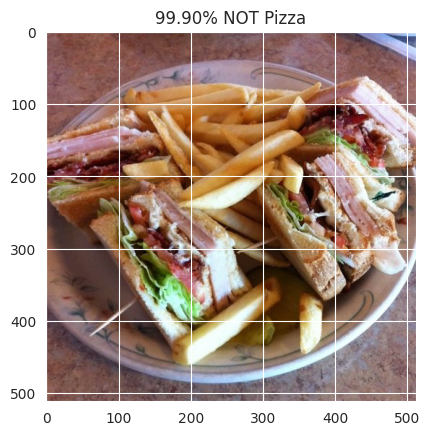

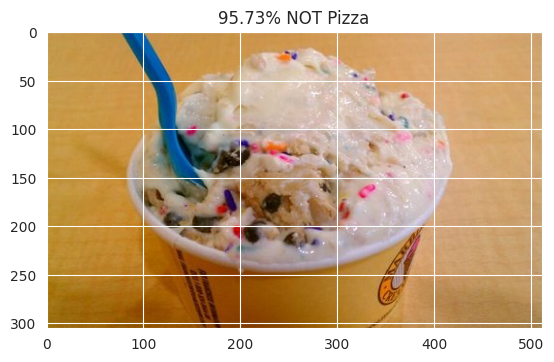

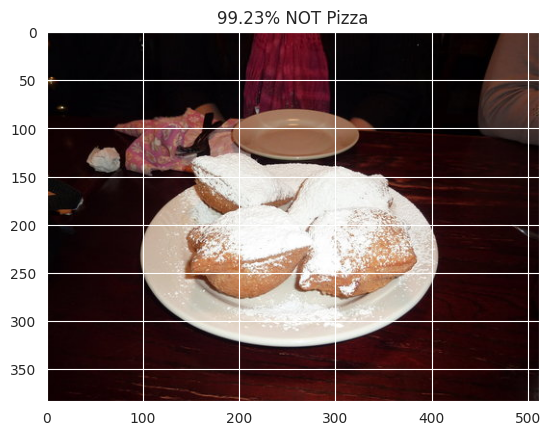

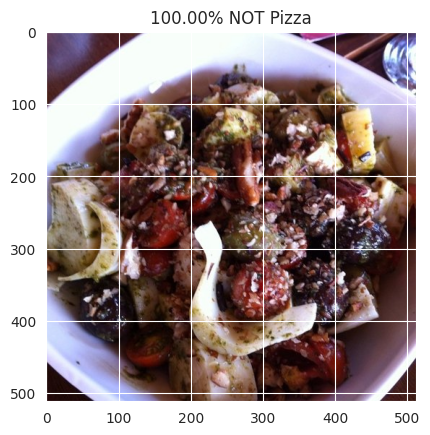

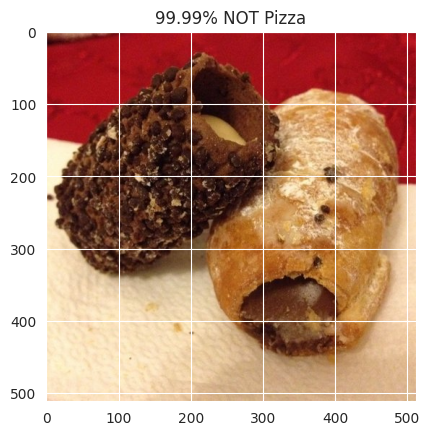

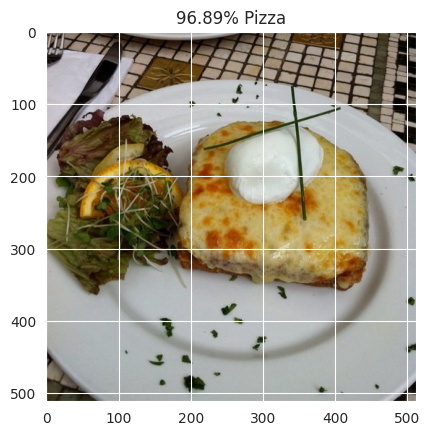

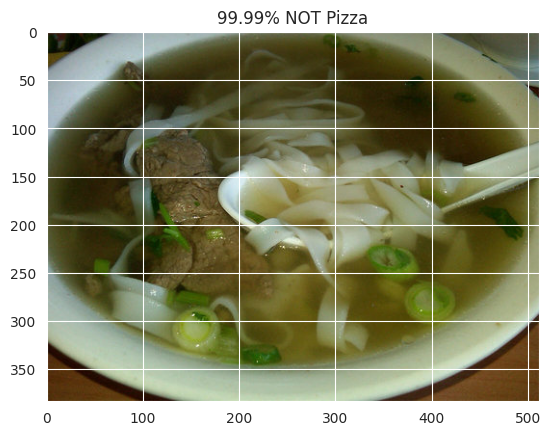

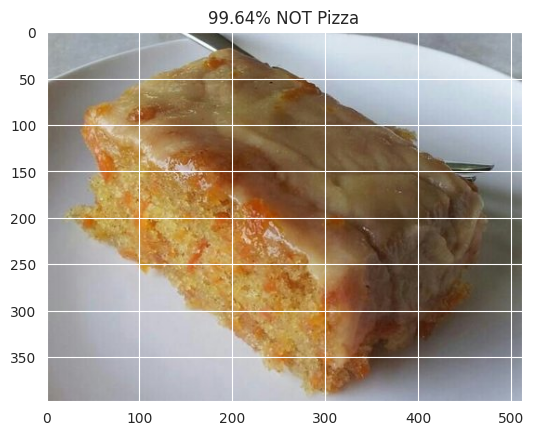

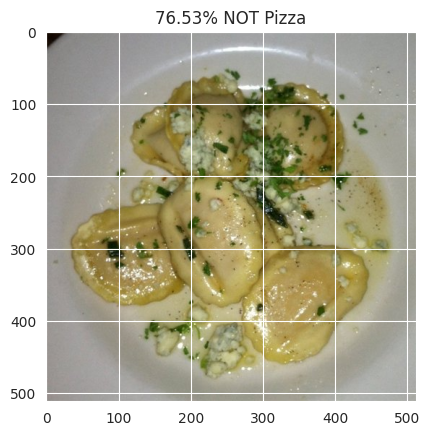

In [22]:
probabilities = model_1.predict(test_generator, 30)
for index, probability in enumerate(probabilities[:15]): # Limit to 15 images
    image_path = TEST_DIR + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Pizza")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% NOT Pizza")
    plt.show()

Saving pepperoni-olive-cheese-pizza-addictive-foods-e1468856431544.jpeg to pepperoni-olive-cheese-pizza-addictive-foods-e1468856431544.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


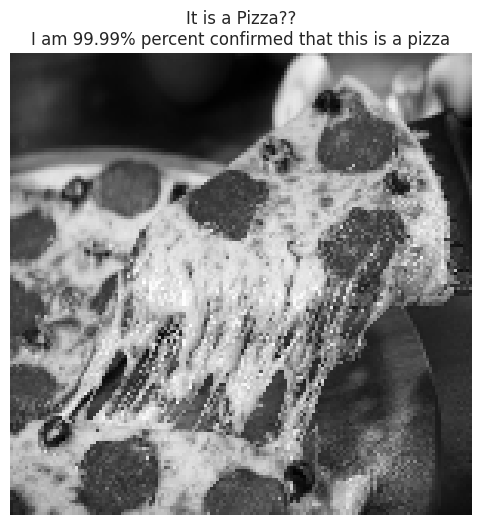

In [26]:
from google.colab import files
from tensorflow.keras.preprocessing import image


uploaded = files.upload()

for fn in uploaded.keys():
  # Load image as grayscale to match the model's input shape
  test_img = image.load_img(fn, target_size=(150, 150), color_mode='grayscale')

  # Preprocessing gambar
  pp_test_img = image.img_to_array(test_img)
  pp_test_img = pp_test_img/255
  pp_test_img = np.expand_dims(pp_test_img, axis=0)

  # Prediksi menggunakan data baru
  test_preds= model_1.predict(pp_test_img)

  # Mencetak hasil prediksi
  plt.figure(figsize=(6,6))
  plt.axis('off')
  if test_preds >= 0.5:
      out = ('I am {:.2%} percent confirmed that this is a pizza'.format(test_preds[0][0]))
  else:
      out = ('I am {:.2%} percent confirmed that this is NOT a pizza'.format(1-test_preds[0][0]))
  plt.title("It is a Pizza??\n"+out)
  # Display the image as grayscale
  plt.imshow(np.squeeze(pp_test_img), cmap='gray') # Use cmap='gray' for grayscale display
  plt.show()

## **Model Save**



In [27]:
import tensorflow as tf

# Simpan kedalam format keras
# model_1.save('pizza_model_savedmodel.keras')

#Simpan kedalam format HDF5
model_1.save('pizza_model_savedmodel.h5')

# impan kedalam format Savedmodel:
# tf.saved_model.save(model_1, 'pizza_model_savedmodel')

# Konversi model ke Tensorflow lite
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

# Simpan TFLite model
with open('pizza_model.tflite', 'wb') as f:
  f.write(tflite_model)

# Konversi model ke TensorFlow.js
# !tensorflowjs_converter --input_format keras pizza_model_savedmodel.keras pizza_model_tfjs

Saved artifact at '/tmp/tmptzyus7ci'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132413193378400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411379864976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411360884016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411360885776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411360882784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411360884544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411361141936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411361140000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411361145104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132411361146864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13241136114440

In [29]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras pizza_model_savedmodel.h5 tfjs_model

  Using cached tensorflowjs-4.22.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorflow_decision_forests-1.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.0 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
  Using cached tf_keras-2.18.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflowjs-4.22.0-py3-none-any.whl (89 kB)
Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.3 MB)
Using cached tensorflow_decision_forests-1.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)
Using cached tf_keras-2.18.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-2.17.0:
      Successfully uninstalled tf_k

2024-12-05 03:14:57.678408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733368497.729870    7831 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733368497.744291    7831 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [30]:
pip freeze > requirements.txt